In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm
import torch as torch
from datasets import load_dataset, load_from_disk
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from datasets import load_dataset
import nltk
nltk.download('punkt')  # Download the necessary resources
from superurop.utilities.utils import *
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from itertools import islice
from concurrent.futures import ProcessPoolExecutor


from nltk.tokenize import sent_tokenize

import torch.nn.functional as F

dataset_manager = DatasetManager()

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
dataname = "len16_sentences"
context_length = 16
buffer = 7
dataset, params = dataset_manager.load_dataset("natural", dataname)
dataset = AutoregressiveDataset(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
model_name = "gpt2"

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/jackking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
def collect_sentences(fw_text):
    sentences = []
    # Limit with islice to avoid checking the length of sentences repeatedly
    for i, sample in tqdm(enumerate(islice(fw_text, 1000000))):
        tokenized_sentences = [tokenizer.encode(sentence)
                               for sentence in sent_tokenize(sample["text"])]
        
        # Filter and add only sentences of the required length
        sentences.extend([s for s in tokenized_sentences if len(s) == context_length])

        if i % 50000 == 0:   
            sentences_tensor = torch.tensor(sentences)
            params = {"dataset_length": len(sentences), "context_length": context_length, "source": "fineweb"}
            dataset_manager.save_dataset("natural", dataname, sentences_tensor, params=params)

In [3]:
fw = load_dataset("HuggingFaceFW/fineweb", name="sample-10BT", split="train", streaming=True)
fw_text = fw.select_columns("text")

In [27]:
collect_sentences(fw_text)

309994it [44:10, 229.33it/s]

In [ ]:
for i in range(10):
    print(tokenizer.decode(dataset[0][i].tolist()))
    print()

In [ ]:
def get_whole_context_surprisals(model, dataloader, device, data_params):
    batch_size = dataloader.batch_size
    surprisals = torch.zeros(data_params["dataset_length"], data_params["context_length"])
    for batch_idx, batch in enumerate(tqdm(dataloader)):
        inputs = batch.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        logits = outputs.logits
        log_probs = -F.log_softmax(logits, dim=-1)
        log_probs = log_probs[:, :-1, :]
        input_ids = inputs[:, 1:]
        indx_start = batch_idx*batch_size
        indx_end = (batch_idx+1)*batch_size
        surprisals[indx_start:indx_end, 1:] = log_probs.gather(-1, input_ids.unsqueeze(-1)).squeeze(-1).detach().cpu()

    return surprisals


def get_surprisals_in_context(model, dataloader, device, context_length, buffer, data_params):
    model.eval()
    #bad naming here. data_params["context_length"] is the length of each sample, context_length is
    # the length of the context used to calculate surprisals
    sample_length = data_params["context_length"]
    surprisals = torch.zeros(data_params["dataset_length"], sample_length)
    context_length = context_length + 1 # the context is 2 but need to look at the third token

    for batch_idx, batch in enumerate(tqdm(dataloader)):
        # shape: (batch_size, sample_length-buffer-1, context_length)
        samples_range = range(buffer-context_length+1, sample_length - context_length+1)
        if isinstance(batch, list):
            batch = torch.stack(batch)
        batch = torch.stack([batch[:, i:i+context_length] for i in samples_range], axis=1).to(device)
        batch_size = batch.shape[0]
        sample_size = batch.shape[1]
        flattened_batch = batch.view(batch_size*sample_size, -1)
        with torch.no_grad():
            outputs = model(flattened_batch)
        outputs = outputs.logits.view(batch_size, sample_size, context_length, -1)

        for sample_idx, logits in enumerate(outputs):
            log_probs = -F.log_softmax(logits, dim=-1)
            log_probs = log_probs[:, -2, :]
            input_ids = batch[sample_idx, :, -1]
            indx_start = batch_idx*batch_size + sample_idx
            surprisals[indx_start, buffer:] = log_probs.gather(-1, input_ids.unsqueeze(-1)).squeeze(-1).flatten().detach().cpu()
            
    return surprisals

In [ ]:
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval()

two_token_context_surprisals = get_surprisals_in_context(model, dataloader, device, 2, buffer, params) 
four_token_context_surprisals = get_surprisals_in_context(model, dataloader, device, 4, buffer, params)
whole_context_surprisals = get_whole_context_surprisals(model, dataloader, device, params)

dataset_manager.save_surprisals("natural", dataname, two_token_context_surprisals, model_name, 2)
dataset_manager.save_surprisals("natural", dataname, four_token_context_surprisals, model_name, 4)
dataset_manager.save_surprisals("natural", dataname, whole_context_surprisals, model_name, "whole")

100%|██████████| 2596/2596 [00:58<00:00, 44.51it/s]


In [ ]:
four_token_context_surprisals[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.6533,
         7.2619, 13.9646, 11.8599,  2.4486,  9.6098,  5.3556,  9.6581,  8.4860])

In [ ]:
def select_sentences(sentences, buffer, two_token_surprisals, four_token_surprisals, whole_surprisals):
    two_token_mean, two_token_std = torch.mean(two_token_surprisals).item(), torch.std(two_token_surprisals).item()
    four_token_mean, four_token_std = torch.mean(four_token_surprisals).item(), torch.std(four_token_surprisals).item()
    whole_mean, whole_std = torch.mean(whole_surprisals).item(), torch.std(whole_surprisals).item()
    short_context_token_indices = torch.zeros(len(sentences), len(sentences[0]))
    long_context_token_indices = torch.zeros(len(sentences), len(sentences[0]))
    short_context_sentences_indices = []
    long_context_sentences_indices = []
    for sentence_idx, sentence in tqdm(enumerate(sentences)):
        short_context_tokens = 0
        long_context_tokens = 0
        for token_idx in range(buffer, len(sentence)):
            two_token_surprisal = two_token_surprisals[sentence_idx, token_idx]
            four_token_surprisal = four_token_surprisals[sentence_idx, token_idx]
            whole_surprisal = whole_surprisals[sentence_idx, token_idx]
            
            #short context clauses
            locally_predictable = two_token_surprisal <= two_token_mean - 0.25*two_token_std
            not_globally_predictable = whole_surprisal >= two_token_surprisal - 0.5*two_token_std #need to compare to two_token_surprisal
            
            #long context clauses
            not_locally_predictable = two_token_surprisal >= two_token_mean + 0.25*two_token_std
            mid_not_too_predictable = four_token_surprisal >= four_token_mean
            globally_predictable = whole_surprisal <= whole_mean - 0.25*whole_std

            if locally_predictable and not_globally_predictable:
                short_context_token_indices[sentence_idx, token_idx] = 1
                short_context_tokens += 1
            elif not_locally_predictable and mid_not_too_predictable and globally_predictable:
                long_context_token_indices[sentence_idx, token_idx] = 1
                long_context_tokens += 1

        if short_context_tokens > len(sentence) - buffer - 3:
            short_context_sentences_indices.append(sentence_idx)
        elif long_context_tokens > len(sentence) - buffer - 3:
            long_context_sentences_indices.append(sentence_idx)

    return short_context_token_indices, long_context_token_indices, np.array(short_context_sentences_indices), np.array(long_context_sentences_indices)

In [ ]:
two_token_context_surprisals = dataset_manager.load_surprisals("natural", dataname, model_name, 2)[0]
four_token_context_surprisals = dataset_manager.load_surprisals("natural", dataname, model_name, 4)[0]
whole_context_surprisals = dataset_manager.load_surprisals("natural", dataname, model_name, "whole")[0]
short_context_token_indices, long_context_token_indices, short_context_sentences, long_context_sentences = select_sentences(dataset, buffer, two_token_context_surprisals, four_token_context_surprisals, whole_context_surprisals)

# dataset_manager.save_dataset("natural", dataname, short_context_token_indices, model_name=model_name, context_type="short", prefix="indices")
# dataset_manager.save_dataset("natural", dataname, long_context_token_indices, model_name, context_type="long", prefix="indices")
# dataset_manager.save_dataset("natural", dataname, short_context_sentences, model_name, context_type="short", prefix="sentences")
# dataset_manager.save_dataset("natural", dataname, long_context_sentences, model_name, context_type="long", prefix="sentences")

166082it [00:57, 2878.46it/s]


In [ ]:
print(len(short_context_sentences)), print(len(long_context_sentences))

2
6


(None, None)

(array([3.4869e+04, 6.1978e+04, 4.6150e+04, 1.8469e+04, 4.0590e+03,
        5.2200e+02, 3.3000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.89999998, 1.79999995, 2.70000005, 3.5999999 ,
        4.5       , 5.4000001 , 6.30000019, 7.19999981, 8.10000038,
        9.        ]),
 <BarContainer object of 10 artists>)

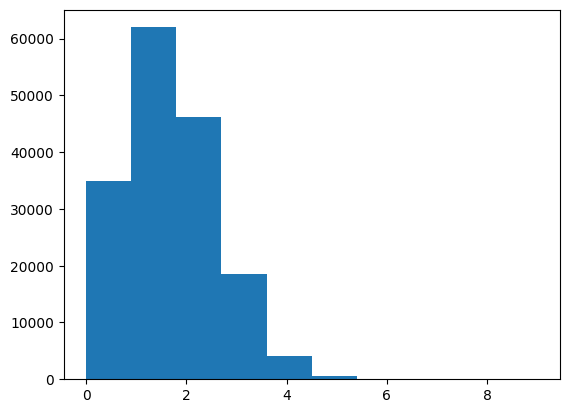

In [ ]:
plt.hist(short_context_token_indices.sum(axis=-1))

In [ ]:
def save_sentence_curvatures(model, sentences, datatype, dataname, model_name):
    model.eval()
    activations = compute_model_activations(model, sentences, device)
    curvatures = compute_model_curvature(activations)
    dataset_manager.save_curvatures(datatype, dataname, curvatures, model_name)